<a href="https://colab.research.google.com/github/AsmaulHusnah028/course/blob/main/Capstone_Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from google.colab import files
%matplotlib inline

# Import TensorFlow Hub
import tensorflow_hub as hub

In [2]:
print(tf.__version__)

2.8.2


### Explore the dataset

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from os import getcwd

print('\u2022 Using TensorFlow Version:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print('GPU is available')

• Using TensorFlow Version: 2.8.2
GPU is available


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pathlib
data_dir = '/content/drive/MyDrive/Capstone Project/Dataset Capstone Project/new_dataset'
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2219


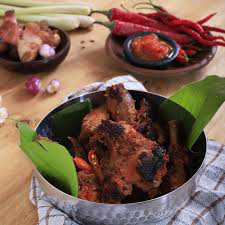

In [7]:
ayam_bakar = list(data_dir.glob('ayam-bakar/*'))
PIL.Image.open(str(ayam_bakar[0]))

### Create a dataset

In [8]:
# create a dataset

# define some parameters for the loader:

batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2219 files belonging to 10 classes.
Using 1776 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2219 files belonging to 10 classes.
Using 443 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['ayam-bakar', 'bakso', 'gado-gado', 'kerak-telor', 'kolak', 'nasi-goreng', 'pempek-palembang', 'rendang', 'sate-madura', 'soto-banjar']


### Visualize the data

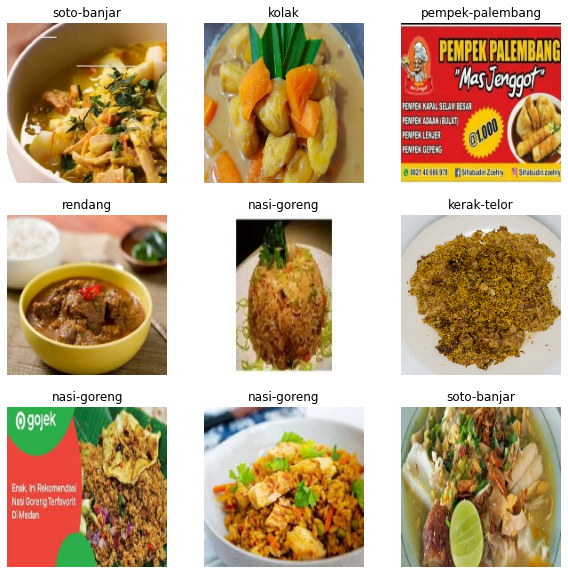

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### configure the dataset for performance

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create the model

In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 8s 100ms/step - loss: 2.2531 - accuracy: 0.1578 - val_loss: 2.1674 - val_accuracy: 0.2325
Epoch 2/10
56/56 [==============================] - 1s 23ms/step - loss: 1.9506 - accuracy: 0.3042 - val_loss: 1.8894 - val_accuracy: 0.3409
Epoch 3/10
56/56 [==============================] - 1s 26ms/step - loss: 1.5616 - accuracy: 0.4807 - val_loss: 1.6992 - val_accuracy: 0.3995
Epoch 4/10
56/56 [==============================] - 1s 23ms/step - loss: 1.2500 - accuracy: 0.5834 - val_loss: 1.4990 - val_accuracy: 0.4695
Epoch 5/10
56/56 [==============================] - 1s 23ms/step - loss: 0.8961 - accuracy: 0.7100 - val_loss: 1.4356 - val_accuracy: 0.5327
Epoch 6/10
56/56 [==============================] - 1s 23ms/step - loss: 0.5146 - accuracy: 0.8445 - val_loss: 1.6154 - val_accuracy: 0.5440
Epoch 7/10
56/56 [==============================] - 1s 23ms/step - loss: 0.3603 - accuracy: 0.9012 - val_loss: 1.6323 - val_accuracy: 0.5824
Epoch 8/10
5

### Visualize the training results

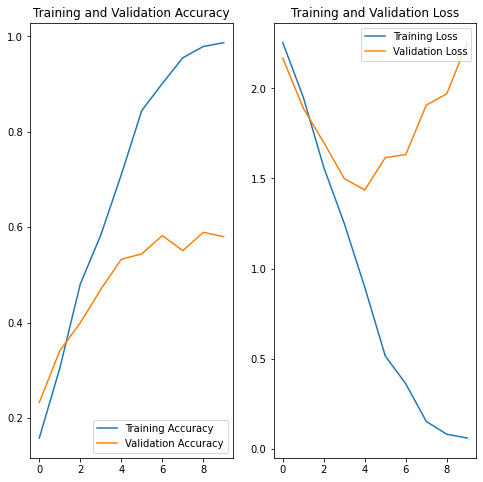

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### For overfitting, using Data Augmentation

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

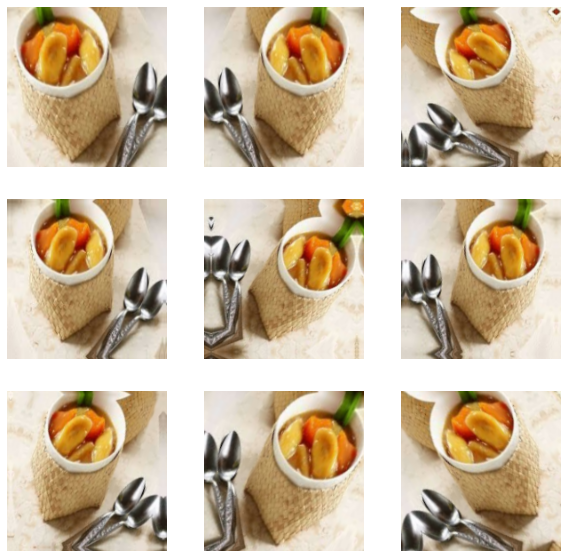

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [28]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### compile model and train the model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [31]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
56/56 [==============================] - 2s 29ms/step - loss: 2.2778 - accuracy: 0.1663 - val_loss: 2.2309 - val_accuracy: 0.1896
Epoch 2/15
56/56 [==============================] - 1s 26ms/step - loss: 2.0060 - accuracy: 0.2701 - val_loss: 1.9409 - val_accuracy: 0.2844
Epoch 3/15
56/56 [==============================] - 2s 32ms/step - loss: 1.7952 - accuracy: 0.3649 - val_loss: 1.7235 - val_accuracy: 0.3589
Epoch 4/15
56/56 [==============================] - 2s 30ms/step - loss: 1.6566 - accuracy: 0.4024 - val_loss: 1.7382 - val_accuracy: 0.3770
Epoch 5/15
56/56 [==============================] - 1s 26ms/step - loss: 1.5426 - accuracy: 0.4569 - val_loss: 1.6353 - val_accuracy: 0.4312
Epoch 6/15
56/56 [==============================] - 1s 26ms/step - loss: 1.4359 - accuracy: 0.4960 - val_loss: 1.7117 - val_accuracy: 0.4063
Epoch 7/15
56/56 [==============================] - 1s 26ms/step - loss: 1.3850 - accuracy: 0.5199 - val_loss: 1.5157 - val_accuracy: 0.4628
Epoch 8/15
56

### Visualize training results

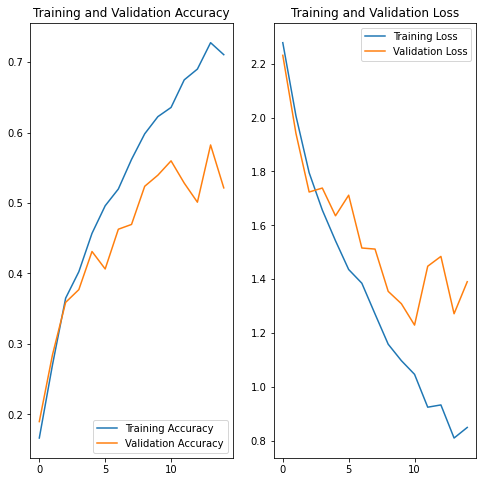

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### predict on new data

In [33]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(
      path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Saving photo (1).jpg to photo (1).jpg
This image most likely belongs to rendang with a 80.52 percent confidence.


In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history_for_project.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_for_project.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.9 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [42]:
import time
saved_model_path = "./model.h5".format(int(time.time()))

model.save(saved_model_path)

In [43]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

In [44]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 420
drwxr-xr-x 2 root root   4096 Jun  6 22:26 assets
-rw-r--r-- 1 root root  26910 Jun  6 22:26 keras_metadata.pb
-rw-r--r-- 1 root root 392117 Jun  6 22:26 saved_model.pb
drwxr-xr-x 2 root root   4096 Jun  6 22:26 variables


In [45]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['sequential_2_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 180, 180, 3)
        name: serving_default_sequential_2_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_5'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
   